https://qiita.com/overlap/items/e7f1077ef8239f454602

In [1]:
import operator, math, random, time
import numpy as np

from deap import algorithms, base, creator, tools, gp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# サンプルデータの生成
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=8, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## lightGBM

In [3]:
import lightgbm as lgb
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

[1]	valid_0's auc: 0.743222
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.774293
[3]	valid_0's auc: 0.786269
[4]	valid_0's auc: 0.796968
[5]	valid_0's auc: 0.798784
[6]	valid_0's auc: 0.802183
[7]	valid_0's auc: 0.802674
[8]	valid_0's auc: 0.805887
[9]	valid_0's auc: 0.810216
[10]	valid_0's auc: 0.808829
[11]	valid_0's auc: 0.812117
[12]	valid_0's auc: 0.812388
[13]	valid_0's auc: 0.813328
[14]	valid_0's auc: 0.815966
[15]	valid_0's auc: 0.815584
[16]	valid_0's auc: 0.816796
[17]	valid_0's auc: 0.819553
[18]	valid_0's auc: 0.819432
[19]	valid_0's auc: 0.820362
[20]	valid_0's auc: 0.822502
[21]	valid_0's auc: 0.823933
[22]	valid_0's auc: 0.825941
[23]	valid_0's auc: 0.826346
[24]	valid_0's auc: 0.828636
[25]	valid_0's auc: 0.829256
[26]	valid_0's auc: 0.829943
[27]	valid_0's auc: 0.830962
[28]	valid_0's auc: 0.831575
[29]	valid_0's auc: 0.83256
[30]	valid_0's auc: 0.834183
[31]	valid_0's auc: 0.835503
[32]	valid_0's auc: 0.836211
[33]	valid_0's auc: 

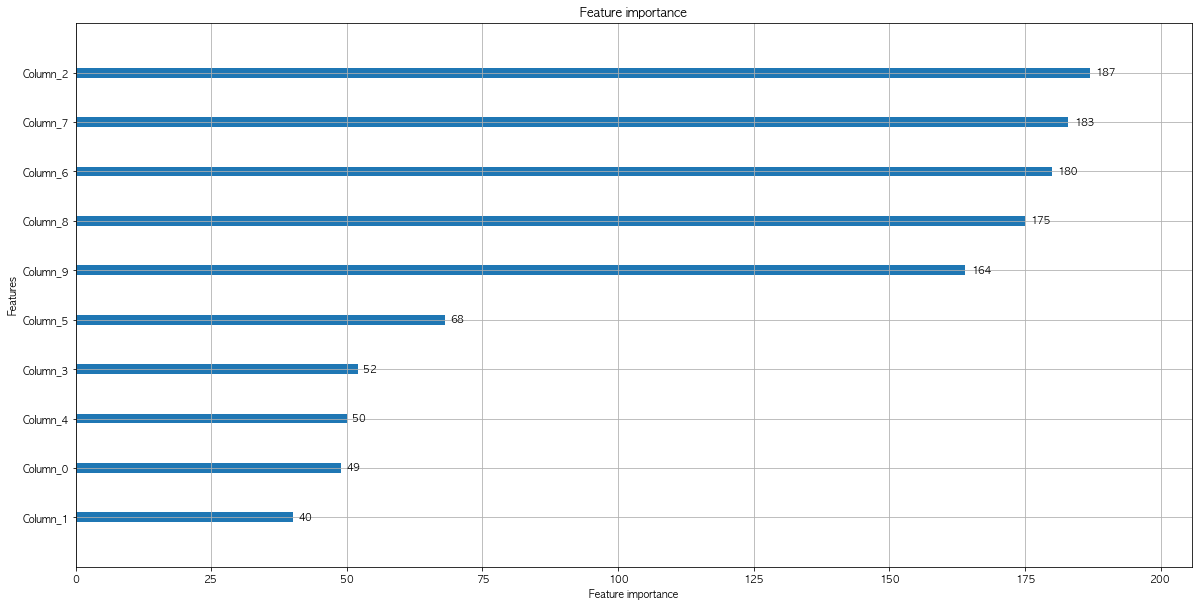

In [4]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'subsample' : 0.8,
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'regression',
    'metric': 'auc',
    }

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(20, 10))
plt.show()

### testでの精度

In [5]:
from sklearn.metrics import roc_auc_score

# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.854653164841


## Feature Generation by Genetic Programming

In [6]:
# ベースラインスコアの算出
clf = LogisticRegression(penalty="l2", C=1.0)
base_train_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))
clf.fit(X_train, y_train)
base_valid_auc = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

In [7]:
# 除算関数の定義
# 左項 / 右項で右項が0の場合1を代入する
def protectedDiv(left, right):
    eps = 1.0e-7
    tmp = np.zeros(len(left))
    tmp[np.abs(right) >= eps] = left[np.abs(right) >= eps] / right[np.abs(right) >= eps]
    tmp[np.abs(right) < eps] = 1.0
    return tmp

In [8]:
# 乱数シード
random.seed(123)

# 適合度を最大化するような木構造を個体として定義
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [9]:
# 初期値の計算
# 学習データの5-fold CVのAUCスコアを評価指標の初期値とする
n_features = X_train.shape[1]
clf = LogisticRegression(penalty="l2", C=1.0)
prev_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))

In [10]:
# メインループ
# resultsに特徴量数、学習データのAUCスコア（5-fold CV）、テストデータのAUCスコアを保持する
# exprsに生成された特徴量の表記を保持する
results = []
exprs = []

In [11]:
for i in tqdm(range(10)):
    # 構文木として利用可能な演算の定義
    pset = gp.PrimitiveSet("MAIN", n_features)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(np.cos, 1)
    pset.addPrimitive(np.sin, 1)
    pset.addPrimitive(np.tan, 1)

    # 関数のデフォルト値の設定
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    # 評価関数の設定
    # 新しく生成した変数を元の変数に加えて5-fold CVを求める
    def eval_genfeat(individual):
        func = toolbox.compile(expr=individual)
        features_train = [X_train[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        X_train_tmp = np.c_[X_train, new_feat_train]
        return np.mean(cross_val_score(clf, X_train_tmp, y_train, scoring="roc_auc", cv=5)),

    # 評価、選択、交叉、突然変異の設定
    # 選択はサイズ10のトーナメント方式、交叉は1点交叉、突然変異は深さ2のランダム構文木生成と定義
    toolbox.register("evaluate", eval_genfeat)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    # 構文木の制約の設定
    # 交叉や突然変異で深さ5以上の木ができないようにする
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)) 

    # 世代ごとの個体とベスト解を保持するクラスの生成
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    # 統計量の表示設定
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # 進化の実行
    # 交叉確率50%、突然変異確率10%、10世代まで進化
    start_time = time.time()
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)
    end_time = time.time()

    # ベスト解とAUCの保持
    best_expr = hof[0]
    best_auc = mstats.compile(pop)["fitness"]["max"]

    # 5-fold CVのAUCスコアが前ステップのAUCを超えていた場合
    # 生成変数を学習、テストデータに追加し、ベストAUCを更新する
    if prev_auc < best_auc:
        # 生成変数の追加
        func = toolbox.compile(expr=best_expr)
        features_train = [X_train[:,i] for i in range(n_features)]
        features_valid = [X_valid[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        new_feat_valid = func(*features_valid)
        X_train = np.c_[X_train, new_feat_train]
        X_valid = np.c_[X_valid, new_feat_valid]

        ### テストAUCの計算（プロット用）
        clf.fit(X_train, y_train)
        train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        valid_auc = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

        # ベストAUCの更新と特徴量数の加算
        prev_auc = best_auc
        n_features += 1

        # 表示と出力用データの保持
        print(n_features, best_auc, train_auc, valid_auc, end_time - start_time)
        results.append([n_features, best_auc, train_auc, valid_auc])
        exprs.append(best_expr)

        # 変数追加後の特徴量数が30を超えた場合break
        if n_features >= 30:
            break

  0%|          | 0/10 [00:00<?, ?it/s]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.741038	0.753865	0.739936	0.00101323	4.52667	14 	2  	2.84182
1  	149   	0.742167	0.767195	0.740082	0.00267789	4.51333	15 	1  	2.75617
2  	181   	0.744845	0.780131	0.738728	0.00552439	4.97333	16 	1  	2.9039 
3  	164   	0.751044	0.781731	0.740025	0.00967249	6.47   	16 	1  	3.36191
4  	165   	0.759953	0.783359	0.739429	0.0143909 	7.82333	16 	1  	3.31041
5  	166   	0.768034	0.791845	0.739429	0.0168249 	9.43   	19 	3  	2.35763
6  	141   	0.771986	0.791845	0.740254	0.0167702 	9.45   	15 	3  	2.58086
7  	155   	0.7737  	0.791845	0.740319	0.0176898 	9.43667	18 	1  	2.67569
8  	132   	0.777558	0.791845	0.739765	0.0178575 	10.1433	18 	4  	2.27071
9  	157   	0.780477	0.791845	0.740514	0.017478  	10.0333	16 	1  	1

 10%|█         | 1/10 [01:16<11:24, 76.01s/it]

10 	161   	0.77832 	0.791845	0.74075 	0.0191025 	9.93   	14 	2  	1.66286
11 0.79184528832 0.793625714064 0.791810506567 75.99736189842224
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.791599	0.803182	0.763602	0.00269303	4.21333	14 	2  	2.59894
1  	175   	0.792828	0.803182	0.766204	0.00273573	4.53333	16 	2  	3.24688
2  	173   	0.795679	0.806216	0.790983	0.0039256 	5.15333	20 	1  	3.44816
3  	161   	0.79897 	0.806216	0.791123	0.00523332	4.34667	18 	1  	2.81895
4  	162   	0.800367	0.806216	0.791216	0.00532864	4.12333	14 	1  	1.82431
5  	171   	0.800847	0.809842	0.791166	0.00610896	5.52333	11 	1  	2.10621
6  	184   	0.801166	0.815129	0.746962	0.00740503	7.03333	15 	1  	1.97962
7  	165   	0.803799	0.815129	0.785897	0.00785447	7.84   	17 	1  	2.62572
8

 20%|██        | 2/10 [02:41<10:30, 78.77s/it]

10 	169   	0.808742	0.815129	0.79154 	0.00869596	8.61   	15 	1  	2.29301
12 0.81512911917 0.817167102108 0.809346466542 85.17557191848755
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.814306	0.820599	0.759642	0.00596334	4.27667	14 	2  	2.45902
1  	159   	0.815264	0.820599	0.758146	0.00405547	3.96   	11 	1  	2.00293
2  	162   	0.816465	0.821354	0.814607	0.00169043	3.89667	10 	1  	1.70078
3  	144   	0.818111	0.821354	0.814666	0.00218709	4.55   	11 	1  	1.40979
4  	156   	0.818658	0.821354	0.814877	0.00263825	3.38   	10 	1  	0.984344
5  	140   	0.819979	0.821354	0.814292	0.00238327	3.05333	9  	1  	0.651016
6  	152   	0.819747	0.821354	0.814635	0.00248943	3.12667	9  	1  	0.728438
7  	155   	0.819709	0.821354	0.814181	0.00252246	3.14667	9  	1  	0.7605

 30%|███       | 3/10 [04:08<09:28, 81.28s/it]

10 	199   	0.819664	0.826639	0.814804	0.0025731 	3.07   	9  	1  	0.604235
13 0.8266385471 0.828813356354 0.817717323327 87.1389639377594
   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.826125	0.829364	0.753852	0.00590983	4.01667	15 	2  	2.60315
1  	161   	0.826557	0.829364	0.77703 	0.00396276	3.48   	11 	1  	1.9034 
2  	190   	0.827298	0.830489	0.810117	0.00142803	3.21333	15 	1  	1.49927
3  	159   	0.828235	0.830489	0.826194	0.00130645	3.43   	7  	1  	0.961821
4  	155   	0.828602	0.830489	0.826194	0.00152998	3.88333	11 	1  	1.20404 
5  	148   	0.829151	0.830489	0.826191	0.00160623	4.89333	11 	1  	1.11742 
6  	165   	0.82909 	0.833149	0.826191	0.00174577	5.13333	11 	1  	1.31993 
7  	165   	0.829067	0.833149	0.826091	0.00182528	5.28333	12 	2  	1.3151

 40%|████      | 4/10 [05:43<08:32, 85.49s/it]

10 	166   	0.83054 	0.833149	0.746564	0.00567941	6.73333	12 	1  	1.65395 
14 0.833148575183 0.835146696329 0.826150719199 95.29870510101318
   	      	                         fitness                          	             size             
   	      	----------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std       	avg	max	min	std   
0  	300   	0.832781	0.836943	0.786657	0.00325497	4  	15 	2  	2.3622
1  	159   	0.833563	0.836943	0.832578	0.000906868	4.10333	12 	1  	2.41923
2  	162   	0.834557	0.836944	0.832576	0.00148135 	6.18333	18 	1  	3.61797
3  	161   	0.835787	0.841238	0.832309	0.00174121 	9.38667	16 	1  	2.66905
4  	176   	0.836013	0.841238	0.83231 	0.00211894 	10.4633	18 	1  	2.56424
5  	191   	0.836761	0.841238	0.832489	0.0028214  	10.7533	19 	1  	2.91533
6  	172   	0.837602	0.841238	0.819145	0.00384713 	9.36   	19 	1  	2.35168
7  	174   	0.837863	0.841238	0.832643	0.00366168 	8.97333	15 	1  	1.82555
8  	

 50%|█████     | 5/10 [07:29<07:38, 91.64s/it]

10 	162   	0.837903	0.841238	0.832664	0.00360366 	8.98667	15 	1  	2.02151
15 0.841238425063 0.843386875647 0.836139774859 105.97414302825928
   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg    	max     	min     	std       	avg    	max	min	std    
0  	300   	0.84114	0.845365	0.811726	0.00176131	4.14667	14 	2  	2.39551
1  	161   	0.841562	0.845365	0.840714	0.00092882	4.71667	17 	1  	3.23363
2  	149   	0.842433	0.845555	0.828483	0.00181765	4.46   	14 	1  	2.41421
3  	166   	0.843543	0.845555	0.840806	0.00190227	3.32333	8  	1  	0.901178
4  	165   	0.843769	0.845555	0.840814	0.00192824	3.51333	9  	1  	1.03109 
5  	141   	0.844194	0.845555	0.840408	0.00183673	4.48333	9  	1  	1.19849 
6  	177   	0.843837	0.845555	0.840846	0.00189899	5.02667	12 	1  	1.28813 
7  	179   	0.84396 	0.845555	0.841056	0.00184913	5.11333	12 	1  	1.31421 
8  	183   	

 60%|██████    | 6/10 [09:27<06:37, 99.49s/it]

10 	158   	0.844296	0.845555	0.840679	0.00178422	5.04333	11 	1  	1.00737 
16 0.845555051024 0.847533630973 0.843156660413 117.762127161026
   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg 	max	min	std    
0  	300   	0.844704	0.847241	0.798406	0.0052549	4.25	14 	2  	2.50882
1  	164   	0.84507 	0.847295	0.759871	0.00697733	4.50667	15 	1  	2.47587
2  	147   	0.845538	0.847517	0.798105	0.00429495	4.46333	13 	1  	2.15453
3  	167   	0.846494	0.847743	0.844995	0.000810909	4.67333	13 	1  	2.11659
4  	176   	0.846659	0.850015	0.844957	0.000918689	6.44667	15 	1  	2.16498
5  	161   	0.846878	0.850015	0.844887	0.00102902 	7.54667	15 	3  	1.79661
6  	160   	0.847235	0.850015	0.844954	0.00125544 	8.29333	16 	1  	2.22874
7  	159   	0.847869	0.850776	0.844864	0.00178624 	7.87667	15 	2  	2.12009
8  	1

 70%|███████   | 7/10 [11:45<05:33, 111.05s/it]

10 	136   	0.849426	0.850776	0.845151	0.00205821 	8.72333	15 	1  	1.85655
17 0.850775567194 0.852981436398 0.84521575985 138.00916600227356
   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg    	max	min	std    
0  	300   	0.849419	0.855161	0.521612	0.0192211	4.09333	14 	2  	2.50159
1  	157   	0.850606	0.855161	0.807344	0.0033857	4.61333	16 	1  	2.87585
2  	190   	0.851306	0.855161	0.80996 	0.0028041	4.64667	16 	1  	2.48633
3  	157   	0.853151	0.855161	0.850079	0.00212296	3.63   	11 	1  	1.44675
4  	166   	0.853553	0.855161	0.836873	0.00235184	3.11333	9  	1  	0.721449
5  	153   	0.853584	0.855161	0.850117	0.0021458 	3.12333	8  	1  	0.590019
6  	164   	0.853561	0.855161	0.85037 	0.00217088	3.09   	9  	1  	0.659722
7  	176   	0.853349	0.855161	0.850264	0.00221315	3.18333	8  	1  	0.745915
8

 80%|████████  | 8/10 [14:22<04:09, 124.95s/it]

10 	166   	0.853684	0.855161	0.850345	0.00212691	3.05667	8  	1  	0.571655
18 0.855160788248 0.85742083032 0.848688242652 157.35863208770752
   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg 	max	min	std    
0  	300   	0.854152	0.856917	0.598547	0.0148342	4.06	15 	2  	2.52383
1  	153   	0.854853	0.857883	0.811102	0.0037851	4.63	14 	2  	2.54816
2  	169   	0.855569	0.857883	0.854515	0.000657887	4.44667	13 	1  	2.22122
3  	168   	0.855975	0.857883	0.840556	0.0013579  	4.15   	13 	1  	1.55161
4  	156   	0.856744	0.857907	0.854515	0.00126659 	4.62333	11 	1  	1.14373
5  	138   	0.857148	0.857907	0.854826	0.00119161 	5.14333	9  	1  	0.967534
6  	159   	0.857114	0.857913	0.854774	0.00125433 	5.74667	10 	1  	1.16153 
7  	155   	0.85726 	0.857913	0.854711	0.0011527  	5.97333	10 	1  	1.22173 
8  	

 90%|█████████ | 9/10 [17:02<02:15, 135.41s/it]

10 	153   	0.857201	0.857913	0.85467 	0.0011912  	6.75   	11 	3  	1.39314 
19 0.857912726137 0.860255400432 0.852923702314 159.79599785804749
   	      	                     fitness                      	             size             
   	      	--------------------------------------------------	------------------------------
gen	nevals	avg     	max    	min     	std       	avg 	max	min	std   
0  	300   	0.857177	0.86182	0.796577	0.00528479	4.07	14 	2  	2.5997
1  	176   	0.858087	0.86182	0.836411	0.00148899	3.95333	13 	1  	2.44223
2  	165   	0.858764	0.86182	0.826799	0.00255701	3.81   	12 	1  	2.11988
3  	161   	0.860327	0.861965	0.857465	0.00182737	3.04   	7  	1  	0.71068
4  	167   	0.860498	0.861965	0.857565	0.00183497	3.21   	8  	1  	0.88651
5  	162   	0.860551	0.861965	0.857469	0.00181968	3.36333	10 	2  	1.03182
6  	160   	0.860739	0.861968	0.857528	0.00176983	3.96667	9  	1  	1.25919
7  	165   	0.860778	0.862112	0.857519	0.00177285	5.02667	11 	1  	1.28295
8  	149   	0.861279	0.86223

100%|██████████| 10/10 [20:15<00:00, 152.60s/it]

10 	168   	0.86124 	0.863594	0.857549	0.00169976	8.23333	16 	1  	2.50178
20 0.863594219635 0.865958727409 0.857048155097 192.67965579032898


In [12]:
# 結果の出力
print()
print("### Results")
print("Baseline AUC train :", base_train_auc)
print("Baseline AUC valid :", base_valid_auc)
print("Best AUC train :", results[-1][1])
print("Best AUC valid :", results[-1][3])


### Results
Baseline AUC train : 0.740923108671
Baseline AUC valid : 0.741797998749
Best AUC train : 0.863594219635
Best AUC valid : 0.857048155097


In [13]:
# 結果のプロット
res = np.array(results)
plt.plot(res[:,0], res[:,1],"o-", color="b", label="train(5-fold CV)")
plt.plot(res[:,0], res[:,3],"o-", color="r", label="test")
plt.plot(10, base_train_auc, "d", color="b", label = "train baseline(5-fold CV)")
plt.plot(10, base_valid_auc, "d", color="r", label = "valid baseline")
plt.xlim(9,31)
plt.grid(which="both")
plt.xlabel('n_features')
plt.ylabel('AUC')
plt.legend(loc="lower right")
plt.savefig("gp_featgen.png")

In [14]:
# 生成した構文木の出力
print()
print("### Generated feature expression")
for expr in exprs:
    print(expr)


### Generated feature expression
sub(cos(add(ARG2, ARG8)), mul(add(ARG8, ARG7), ARG6))
mul(ARG8, sub(sub(sub(ARG9, ARG7), ARG2), ARG2))
mul(ARG2, mul(ARG7, ARG9))
mul(ARG2, mul(neg(neg(ARG8)), ARG7))
mul(sub(protectedDiv(ARG13, ARG8), neg(ARG8)), neg(ARG6))
mul(sub(ARG9, ARG8), ARG14)
mul(ARG2, mul(ARG6, sub(sub(ARG10, ARG6), ARG6)))
mul(ARG9, ARG2)
mul(sin(sin(sin(cos(ARG6)))), ARG7)
mul(ARG17, add(add(ARG8, ARG9), ARG9))


## lightGBM(2)

[1]	valid_0's auc: 0.735962
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.768954
[3]	valid_0's auc: 0.782971
[4]	valid_0's auc: 0.791694
[5]	valid_0's auc: 0.792907
[6]	valid_0's auc: 0.800538
[7]	valid_0's auc: 0.804382
[8]	valid_0's auc: 0.809861
[9]	valid_0's auc: 0.814734
[10]	valid_0's auc: 0.81677
[11]	valid_0's auc: 0.820437
[12]	valid_0's auc: 0.821808
[13]	valid_0's auc: 0.824414
[14]	valid_0's auc: 0.827387
[15]	valid_0's auc: 0.829355
[16]	valid_0's auc: 0.831069
[17]	valid_0's auc: 0.832733
[18]	valid_0's auc: 0.834359
[19]	valid_0's auc: 0.836285
[20]	valid_0's auc: 0.838337
[21]	valid_0's auc: 0.840295
[22]	valid_0's auc: 0.841882
[23]	valid_0's auc: 0.841942
[24]	valid_0's auc: 0.842822
[25]	valid_0's auc: 0.843656
[26]	valid_0's auc: 0.843754
[27]	valid_0's auc: 0.844991
[28]	valid_0's auc: 0.84553
[29]	valid_0's auc: 0.846289
[30]	valid_0's auc: 0.848094
[31]	valid_0's auc: 0.849114
[32]	valid_0's auc: 0.850293
[33]	valid_0's auc: 0

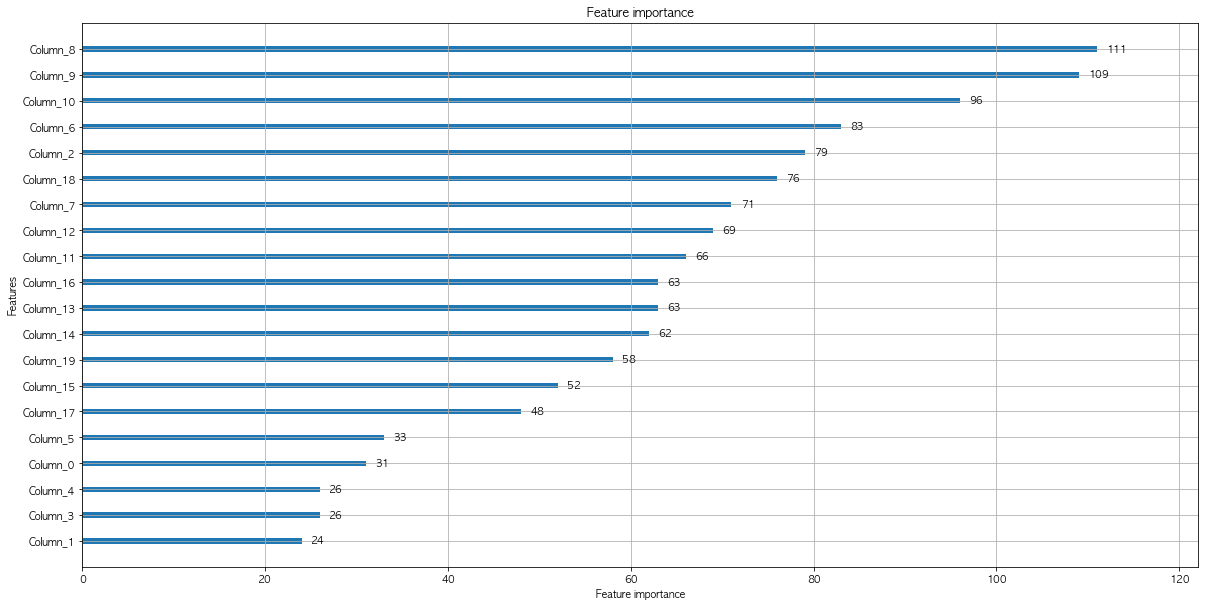

In [20]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'subsample' : 0.8,
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'regression',
    'metric': 'auc',
    }

# 上記のパラメータでモデルを学習する
model2 = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model2, figsize=(20, 10))
plt.show()

### testでの検証

In [21]:
# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model2.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.770025005606
